# Music Composer Identification using Deep Learning

The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

## Project Team & Responsibilities:

* **Dom:** Data Collection, Data Preprocessing (MIDI conversion, segmentation, augmentation), Feature Extraction (Piano Rolls for CNN, Sequential Features for LSTM).
* **Santosh:** CNN Model Building, Training, Evaluation, Optimization.
* **Jim:** LSTM Model Building, Training, Evaluation, Optimization.

## Project Roadmap & Status:

Here's a breakdown of our project phases and current status:

1.  **Initial Setup & Data Download (COMPLETED by Jim):**
    * Basic imports are set up.
    * The `blanderbuss/midi-classic-music` dataset has been downloaded from Kaggle.
    * *Status:* Ready for data processing.

2.  **Data Preprocessing & Feature Extraction (COMPLETED by Dom):**
    * **Goal:** Convert raw MIDI files into numerical features (Piano Rolls for CNNs, Sequential Features for LSTMs) and augment dataset.
    * **Responsible:** Dom.
    * *Current Status:* Completed / Needs implementation of the sections below.

3.  **Model Building (NEXT STEP for Team):**
    * **Goal:** Design CNN and LSTM model architectures.
    * **Responsible:** Santosh (CNN), Jim (LSTM).
    * *Dependencies:* Requires processed data from Phase 2.

4.  **Model Training & Evaluation (AFTER Model Building):**
    * **Goal:** Train the models and evaluate their performance using metrics like accuracy, precision, and recall.
    * **Responsible:** Santosh (CNN), Jim (LSTM).
    * *Dependencies:* Requires built models from Phase 3.

5.  **Model Optimization (Post Training):**
    * **Goal:** Fine-tune model hyperparameters to improve performance.
    * **Responsible:** Santosh (CNN), Jim (LSTM) & Dom (Feature Engineering).
    * *Dependencies:* Requires initial model training.

In [1]:
# Imports
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, TensorDataset, random_split
import pandas as pd
import pickle
import collections
import random
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


Data Collection
The dataset contains the midi files of compositions from well-known classical composers like Bach, Beethoven, Chopin, and Mozart. The dataset has been labeled with the name of the composer for each score. Predictions are performed for only the below composers:

1-Bach

2-Beethoven

3-Chopin

4-Mozart

In [2]:
#%pip install kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("blanderbuss/midi-classic-music")

print("Path to dataset files:", path)

/home/santosh/env/aai-511-final-project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/santosh/.cache/kagglehub/datasets/blanderbuss/midi-classic-music/versions/1


In [3]:
# # List all files in the dataset path
# for root, dirs, files in os.walk(path):
#     for file in files:
#         #print(os.path.join(root, file))
#         # Check if the file is a MIDI file and contains 'bach' in its name.
#         # There are other composers that need to be processed too.
#         if (file.endswith('.mid') or file.endswith('.midi')) and 'bach' in file.lower():
#             print(f"Found MIDI file: {file}")
#             # Add file to Bach dataset processing logic here


Convert MIDI file to something useful for LSTM and CNN.

In [4]:
# I will place these here so they run after Kaggle download, as I encountered conflicts with the initial setup when adding above.
# !pip install music21
# !pip install pretty_midi
#!pip install --upgrade numpy # Ensure I have a recent numpy version

In [5]:
import music21
import pretty_midi
# Ensure numpy is up-to-date
import numpy as np  # Already imported, but good to have here for clarity

/home/santosh/env/aai-511-final-project/lib/python3.12/site-packages/pretty_midi/instrument.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.


In [6]:
# Data Preprocessing and Feature Extraction
HOME_DIR = Path.home()
KAGGLE_DOWNLOAD_PATH = HOME_DIR / ".cache" / "kagglehub" / "datasets" / "blanderbuss" / "midi-classic-music" / "versions" / "1"
MIDI_DIR = str(KAGGLE_DOWNLOAD_PATH)

OUTPUT_DIR = "./content/processed_data/"
SEGMENT_DURATION_SECONDS = 5
SAMPLES_PER_SECOND = 100

PITCH_LOW = 21
PITCH_HIGH = 108
NUM_PITCHES = PITCH_HIGH - PITCH_LOW + 1

AUGMENT_TRANSPOSITION_STEPS = [-3, -2, -1, 1, 2, 3]
AUGMENT_TEMPO_SCALES = [0.9, 1.1]

# Defines composers
COMPOSERS = ["Bach", "Beethoven", "Chopin", "Mozart"]

# Creates output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"MIDI data will be processed from: {MIDI_DIR}")
print(f"Processed data will be saved to: {OUTPUT_DIR}")

#DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 42  # Set a seed for reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    print("Using CUDA GPU")
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False


MIDI data will be processed from: /home/santosh/.cache/kagglehub/datasets/blanderbuss/midi-classic-music/versions/1
Processed data will be saved to: ./content/processed_data/
Using CUDA GPU


###Feature Extraction : Extracts features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.

Here, the preprocessed MIDI segments are converted into numerical representations. I've generated different formats for the CNN and LSTM models to leverage the strengths of each.

* **For CNNs: The Piano Roll**
    * **Purpose:** CNNs excel at recognizing visual patterns. A piano roll converts music into a 2D image (pitch vs. time), allowing the CNN to "see" and learn characteristic melodic shapes, harmonic voicings, and rhythmic patterns that define a composer's style.
    * **Details:** The piano roll captures note activity (velocity) across a defined pitch range (MIDI 21-108) over time, sampled at 100 samples per second. All outputs are normalized to [0,1] and padded/truncated to a consistent shape.
* **For LSTMs: Sequential Features (Chroma & Note Density)**
    * **Purpose:** LSTMs are great tools for understanding temporal sequences. These features describe the harmonic content and musical activity at each point in time, allowing the LSTM to learn how a composer's musical ideas evolve.
    * **Details:** Each time step in the sequence contains a 12-element Pitch Class Profile (Chroma) representing harmonic presence (e.g., C, C#, D) and a single value for overall note density/volume. These are also sampled at 100 samples per second and normalized.

In [7]:
# Feature Extraction - midi_to_sequential_features (for LSTMs)
# This function extracts time-series features like Pitch Class Profiles and note density from a MIDI segment for LSTMs

def midi_to_sequential_features(midi_data_segment: pretty_midi.PrettyMIDI, duration: float,
                                samples_per_second: int, pitch_low: int, pitch_high: int) -> np.ndarray:
    if not midi_data_segment.instruments:
        return None

    num_target_time_steps = int(duration * samples_per_second)
    num_features_per_timestep = 12 + 1 # Chroma + Note Density
    sequential_features = np.zeros((num_target_time_steps, num_features_per_timestep), dtype=np.float32)

    chroma_features = midi_data_segment.get_chroma(fs=samples_per_second).T
    # print("Original chroma shape:", chroma_features.shape)  # should be (12, T)
    if chroma_features.shape[0] < num_target_time_steps:
        padding_needed = num_target_time_steps - chroma_features.shape[0]
        chroma_features = np.pad(chroma_features, ((0, padding_needed), (0, 0)), mode='constant')
    elif chroma_features.shape[0] > num_target_time_steps:
        chroma_features = chroma_features[:num_target_time_steps, :]

    note_density = np.zeros(num_target_time_steps, dtype=np.float32)
    for instrument in midi_data_segment.instruments:
        for note in instrument.notes:
            start_idx = int(note.start * samples_per_second)
            end_idx = int(note.end * samples_per_second)
            start_idx = max(0, min(start_idx, num_target_time_steps - 1))
            end_idx = max(0, min(end_idx, num_target_time_steps - 1))
            if end_idx >= start_idx:
                note_density[start_idx:end_idx] += note.velocity

    max_density = np.max(note_density)
    if max_density > 0:
        note_density /= max_density

    sequential_features[:, :12] = chroma_features
    sequential_features[:, 12] = note_density

    return sequential_features

In [8]:
from typing import Optional

# Feature Extraction - midi_to_piano_roll (for CNNs)
# This function converts a MIDI segment into a 2D image-like "piano roll" for CNNs.
def is_piano(instrument: pretty_midi.Instrument) -> bool:
    # Check program number (0-7 are all piano-related in General MIDI)
    return not instrument.is_drum and 0 <= instrument.program <= 7

def midi_to_piano_roll(midi_data_segment: pretty_midi.PrettyMIDI, duration: float,
                        samples_per_second: int, pitch_low: int, pitch_high: int) -> Optional[np.ndarray]:
    if not midi_data_segment.instruments:
        return None
    piano = None # Default instrument of acoustic piano, will be updated if a piano instrument is found
    for instrument in midi_data_segment.instruments:
        if is_piano(instrument):
            piano = instrument
    if (piano is None):
        # print("No piano instrument found in MIDI segment.")
        return None

    # Fix: Use 'times' parameter and slice the piano roll to get the desired pitch range
    piano_roll = piano.get_piano_roll(fs=samples_per_second)

    # Slice to get the desired pitch range (pitch_low to pitch_high)
    piano_roll = piano_roll[pitch_low:pitch_high+1, :]
    piano_roll = piano_roll / 127.0

    num_target_time_steps = int(duration * samples_per_second)
    num_pitches = pitch_high - pitch_low + 1  # Should be 88
    current_time_steps = piano_roll.shape[1]

    if current_time_steps < num_target_time_steps:
        padding = np.zeros((num_pitches, num_target_time_steps - current_time_steps), dtype=np.float32)
        piano_roll = np.hstack([piano_roll, padding])
    elif current_time_steps > num_target_time_steps:
        piano_roll = piano_roll[:, :num_target_time_steps]

    return piano_roll.reshape(num_pitches, num_target_time_steps, 1)


In [9]:
# Utility Function - create_pretty_midi_segment
# This function extracts a specific time segment from a larger MIDI file.

def create_pretty_midi_segment(full_midi_data: pretty_midi.PrettyMIDI, start_time: float, end_time: float) -> pretty_midi.PrettyMIDI:
    segment_pm = pretty_midi.PrettyMIDI()
    for instrument in full_midi_data.instruments:
        new_instrument = pretty_midi.Instrument(program=instrument.program, is_drum=instrument.is_drum, name=instrument.name)
        for note in instrument.notes:
            if note.end > start_time and note.start < end_time:
                new_note = pretty_midi.Note(
                    velocity=note.velocity,
                    pitch=note.pitch,
                    start=max(0.0, note.start - start_time),
                    end=min(end_time - start_time, note.end - start_time)
                )
                if new_note.end > new_note.start:
                    new_instrument.notes.append(new_note)
        if new_instrument.notes:
            segment_pm.instruments.append(new_instrument)
    return segment_pm

In [10]:
# Utility Function - apply_augmentation
# This function modifies a MIDI segment by transposing its pitch or scaling its tempo.

def apply_augmentation(midi_data_segment: pretty_midi.PrettyMIDI, augmentation_type: str, value) -> pretty_midi.PrettyMIDI:
    augmented_midi = pretty_midi.PrettyMIDI()
    for instrument in midi_data_segment.instruments:
        new_instrument = pretty_midi.Instrument(program=instrument.program, is_drum=instrument.is_drum, name=instrument.name)
        for note in instrument.notes:
            new_note = pretty_midi.Note(note.velocity, note.pitch, note.start, note.end)
            new_instrument.notes.append(new_note)
        augmented_midi.instruments.append(new_instrument)

    if augmentation_type == 'transpose':
        for instrument in augmented_midi.instruments:
            for note in instrument.notes:
                note.pitch = int(max(0, min(127, note.pitch + value)))
    elif augmentation_type == 'tempo_scale':
        scale_value = float(value)
        for instrument in augmented_midi.instruments:
            for note in instrument.notes:
                note.start *= scale_value
                note.end *= scale_value
    else:
        raise ValueError(f"Unknown augmentation type: {augmentation_type}")
    return augmented_midi

In [11]:
def extract_segments_from_midi(midi_path, segment_duration=5.0, samples_per_second=100):
    try:
        full_midi = pretty_midi.PrettyMIDI(midi_path)
    except Exception as e:
        print(f"Error loading {midi_path}: {e}")
        return []

    total_duration = full_midi.get_end_time()
    segments = []

    for start_time in np.arange(0, total_duration, segment_duration):
        end_time = min(start_time + segment_duration, total_duration)

        segment = pretty_midi.PrettyMIDI()
        for instrument in full_midi.instruments:
            new_instrument = pretty_midi.Instrument(program=instrument.program, is_drum=instrument.is_drum)
            for note in instrument.notes:
                if start_time <= note.start < end_time:
                    new_note = pretty_midi.Note(
                        velocity=note.velocity,
                        pitch=note.pitch,
                        start=note.start - start_time,
                        end=min(note.end, end_time) - start_time
                    )
                    new_instrument.notes.append(new_note)
            if new_instrument.notes:
                segment.instruments.append(new_instrument)

        # Only append segments with valid instruments
        if segment.instruments:
            segments.append(segment)

    return segments



### Data Processing Loop & Output Conclusion

This section orchestrates the loading of MIDI files, segmenting them, applying all augmentations, extracting features, and finally saving the processed data.

* **Process:** Iterates through each composer's MIDI files, segments them, applies both transposition and tempo scaling for each segment, and then generates both CNN and LSTM features.
* **Output Data:** The processed features and corresponding labels are saved as `.pkl` files in the `/content/processed_data/` directory.

---

#### **The data is ready for model training!**

* **For CNN Model (Santosh):**
    * Load `features_cnn.pkl`.
    * Expected input shape: `(num_segments, 88, 500, 1)` - (total samples, pitches, time steps, channels).
* **For LSTM Model (Jim):**
    * Load `features_lstm.pkl`.
    * Expected input shape: `(num_segments, 500, 13)` - (total samples, time steps, features per time step).
* **Labels:**
    * Load `labels.pkl` (numerical labels corresponding to composers).
    * Load `composer_to_label.pkl` and `label_to_composer.pkl` to map between numerical labels and composer names.

You can/should convert these NumPy arrays to PyTorch tensors for your models (e.g., `torch.tensor(data, dtype=torch.float32)` for features, `torch.tensor(labels, dtype=torch.long)` for labels).


In [12]:
# Define label mappings
composer_to_label = {composer: i for i, composer in enumerate(COMPOSERS)}
label_to_composer = {i: composer for composer, i in composer_to_label.items()}

# Define lists to hold features and labels
# These will be used to store the extracted features and corresponding labels for each composer.
# They will be converted to NumPy arrays later for model training.
features_cnn = []
features_lstm = []
labels = []

# Iterate through each composer
for composer in COMPOSERS:
    composer_dir = os.path.join(MIDI_DIR)
    print(f"Processing composer: {composer}")

    for root, dirs, files in os.walk(path):
        for file in files:
            # print(os.path.join(root, file))
            # Check if the file is a MIDI file and contains 'bach' in its name.
            # There are other composers that need to be processed too.
            if (file.endswith('.mid') or file.endswith('.midi')) and composer.lower() in file.lower():
                midi_path = os.path.join(root, file)
                # print("Reading file: ", file)

                try:
                    segments = extract_segments_from_midi(midi_path, SEGMENT_DURATION_SECONDS, SAMPLES_PER_SECOND)
                except Exception as e:
                    # print(f"Skipping {file}: {e}")
                    continue

                for segment in segments:
                    all_augmented = [segment]

                    for step in AUGMENT_TRANSPOSITION_STEPS:
                        all_augmented.append(apply_augmentation(segment, 'transpose', step))
                    for scale in AUGMENT_TEMPO_SCALES:
                        all_augmented.append(apply_augmentation(segment, 'tempo_scale', scale))

                    for augmented_segment in all_augmented:
                        # CNN Features
                        piano_roll = midi_to_piano_roll(augmented_segment, duration=SEGMENT_DURATION_SECONDS,
                                                        samples_per_second=SAMPLES_PER_SECOND,
                                                        pitch_low=PITCH_LOW, pitch_high=PITCH_HIGH)
                        # LSTM Features
                        sequential = midi_to_sequential_features(augmented_segment, duration=SEGMENT_DURATION_SECONDS,
                                                                 samples_per_second=SAMPLES_PER_SECOND,
                                                                 pitch_low=PITCH_LOW, pitch_high=PITCH_HIGH)

                        # Append label only if both features were generated
                        if piano_roll is not None and sequential is not None:
                            features_cnn.append(piano_roll)
                            features_lstm.append(sequential)
                            labels.append(composer_to_label[composer])

print("Finished processing all composers.")

# Convert to NumPy arrays
np_features_cnn = np.array(features_cnn, dtype=np.float32)
np_features_lstm = np.array(features_lstm, dtype=np.float32)
labels = np.array(labels, dtype=np.int64)

# Save to disk
with open(os.path.join(OUTPUT_DIR, 'features_cnn.pkl'), 'wb') as f:
    pickle.dump(np_features_cnn, f)

with open(os.path.join(OUTPUT_DIR, 'features_lstm.pkl'), 'wb') as f:
    pickle.dump(np_features_lstm, f)

with open(os.path.join(OUTPUT_DIR, 'labels.pkl'), 'wb') as f:
    pickle.dump(labels, f)

with open(os.path.join(OUTPUT_DIR, 'composer_to_label.pkl'), 'wb') as f:
    pickle.dump(composer_to_label, f)

with open(os.path.join(OUTPUT_DIR, 'label_to_composer.pkl'), 'wb') as f:
    pickle.dump(label_to_composer, f)


Processing composer: Bach
Processing composer: Beethoven
Processing composer: Chopin
Error loading /home/santosh/.cache/kagglehub/datasets/blanderbuss/midi-classic-music/versions/1/midiclassics/Varios - Ti'tulo desconocido/a_h/chopin7.mid: MThd not found. Probably not a MIDI file
Processing composer: Mozart
Finished processing all composers.


In [13]:
# Print summary of saved data
print(f"Saved {len(np_features_cnn)} CNN features and {len(np_features_lstm)} LSTM features.")
print(f"Saved {len(labels)} labeled examples for training.")

Saved 10215 CNN features and 10215 LSTM features.
Saved 10215 labeled examples for training.


CNN Input: (batch_size, 1, 88, 500) → channel-first PyTorch format (grayscale piano roll)
CNN Output per segment: (batch_size, time_steps=some_N, features_per_step=some_M)


In [14]:
class ComposerCNN(nn.Module):
    def __init__(self, num_pitches, num_time_steps):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Use integer division and guard with adaptive pooling if needed
        pooled_pitches = max(1, num_pitches // 4)
        pooled_steps   = max(1, num_time_steps // 4)
        self.fc1 = nn.Linear(64 * pooled_pitches * pooled_steps, 128)
        self.fc2 = nn.Linear(128, len(COMPOSERS))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [15]:
model_cnn = ComposerCNN(NUM_PITCHES, int(SEGMENT_DURATION_SECONDS * SAMPLES_PER_SECOND)).to(DEVICE)


Model Building: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.


LSTM Input Shape: (batch_size, time_steps, features_per_step) → same as (batch_size, seq_len, input_size)

In [16]:
# Hyperparameters
input_size = 13         # 12 chroma + 1 note density
hidden_size = 128       # Can be tuned
num_layers = 2          # Can be tuned
num_classes = len(COMPOSERS)    # based on the number of composer labels
batch_size = 64
num_epochs = 30
learning_rate = 0.001


In [17]:

# ------------------------------
# Define the LSTM Model
# ------------------------------
class ComposerLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(ComposerLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=0.3,
                            bidirectional=False)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # output: (batch_size, seq_len, hidden_size)
        out = lstm_out[:, -1, :]    # Take last time step
        out = self.fc(out)
        return out

# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = ComposerLSTM(input_size, hidden_size, num_layers, num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)



In [18]:

# ------------------------------
# Load Preprocessed Data
# ------------------------------
with open(os.path.join(OUTPUT_DIR, 'features_lstm.pkl'), 'rb') as f:
    X = pickle.load(f)
with open(os.path.join(OUTPUT_DIR, 'labels.pkl'), 'rb') as f:
    y = pickle.load(f)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)        # Shape: (N, 500, 13)
y_tensor = torch.tensor(y, dtype=torch.long)           # Shape: (N,)

print(X_tensor.shape)  # Should be (N, 500, 13
print(y_tensor.shape)  # Should be (N,)

# Ensure the input tensor is 3D: (batch_size, seq_len, input_size)
if X_tensor.ndim == 2:
    X_tensor = X_tensor.unsqueeze(1)  # Add a dimension for seq_len if missing
elif X_tensor.ndim != 3:
    raise ValueError(f"Expected X_tensor to be 2D or 3D, got {X_tensor.ndim}D tensor instead.")

# Dataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, pin_memory=True, num_workers=2)


torch.Size([10215, 500, 13])
torch.Size([10215])


In [19]:
train_losses = []
val_accuracies = []

Model Training: Train the deep learning model using the pre-processed and feature-extracted data.


In [20]:
# ------------------------------
# Training Loop
# ------------------------------
for epoch in range(num_epochs):
    lstm_model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = lstm_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    lstm_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(DEVICE), y_val.to(DEVICE)
            outputs = lstm_model(X_val)
            _, predicted = torch.max(outputs.data, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()

    val_accuracy = 100 * correct / total
    train_losses.append(avg_train_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Save the model
torch.save(lstm_model.state_dict(), "composer_lstm_model.pth")

Epoch [1/30], Loss: 0.7121, Validation Accuracy: 79.30%
Epoch [2/30], Loss: 0.5912, Validation Accuracy: 81.74%
Epoch [3/30], Loss: 0.5351, Validation Accuracy: 82.38%
Epoch [4/30], Loss: 0.4886, Validation Accuracy: 83.60%
Epoch [5/30], Loss: 0.4345, Validation Accuracy: 85.12%
Epoch [6/30], Loss: 0.5013, Validation Accuracy: 85.41%
Epoch [7/30], Loss: 0.5675, Validation Accuracy: 83.55%
Epoch [8/30], Loss: 0.4388, Validation Accuracy: 86.10%
Epoch [9/30], Loss: 0.3753, Validation Accuracy: 87.37%
Epoch [10/30], Loss: 0.3370, Validation Accuracy: 86.05%
Epoch [11/30], Loss: 0.3140, Validation Accuracy: 89.04%
Epoch [12/30], Loss: 0.2904, Validation Accuracy: 90.01%
Epoch [13/30], Loss: 0.3650, Validation Accuracy: 87.91%
Epoch [14/30], Loss: 0.3133, Validation Accuracy: 88.15%
Epoch [15/30], Loss: 0.2927, Validation Accuracy: 87.52%
Epoch [16/30], Loss: 0.3426, Validation Accuracy: 85.07%
Epoch [17/30], Loss: 0.3019, Validation Accuracy: 85.66%
Epoch [18/30], Loss: 0.2809, Validation 

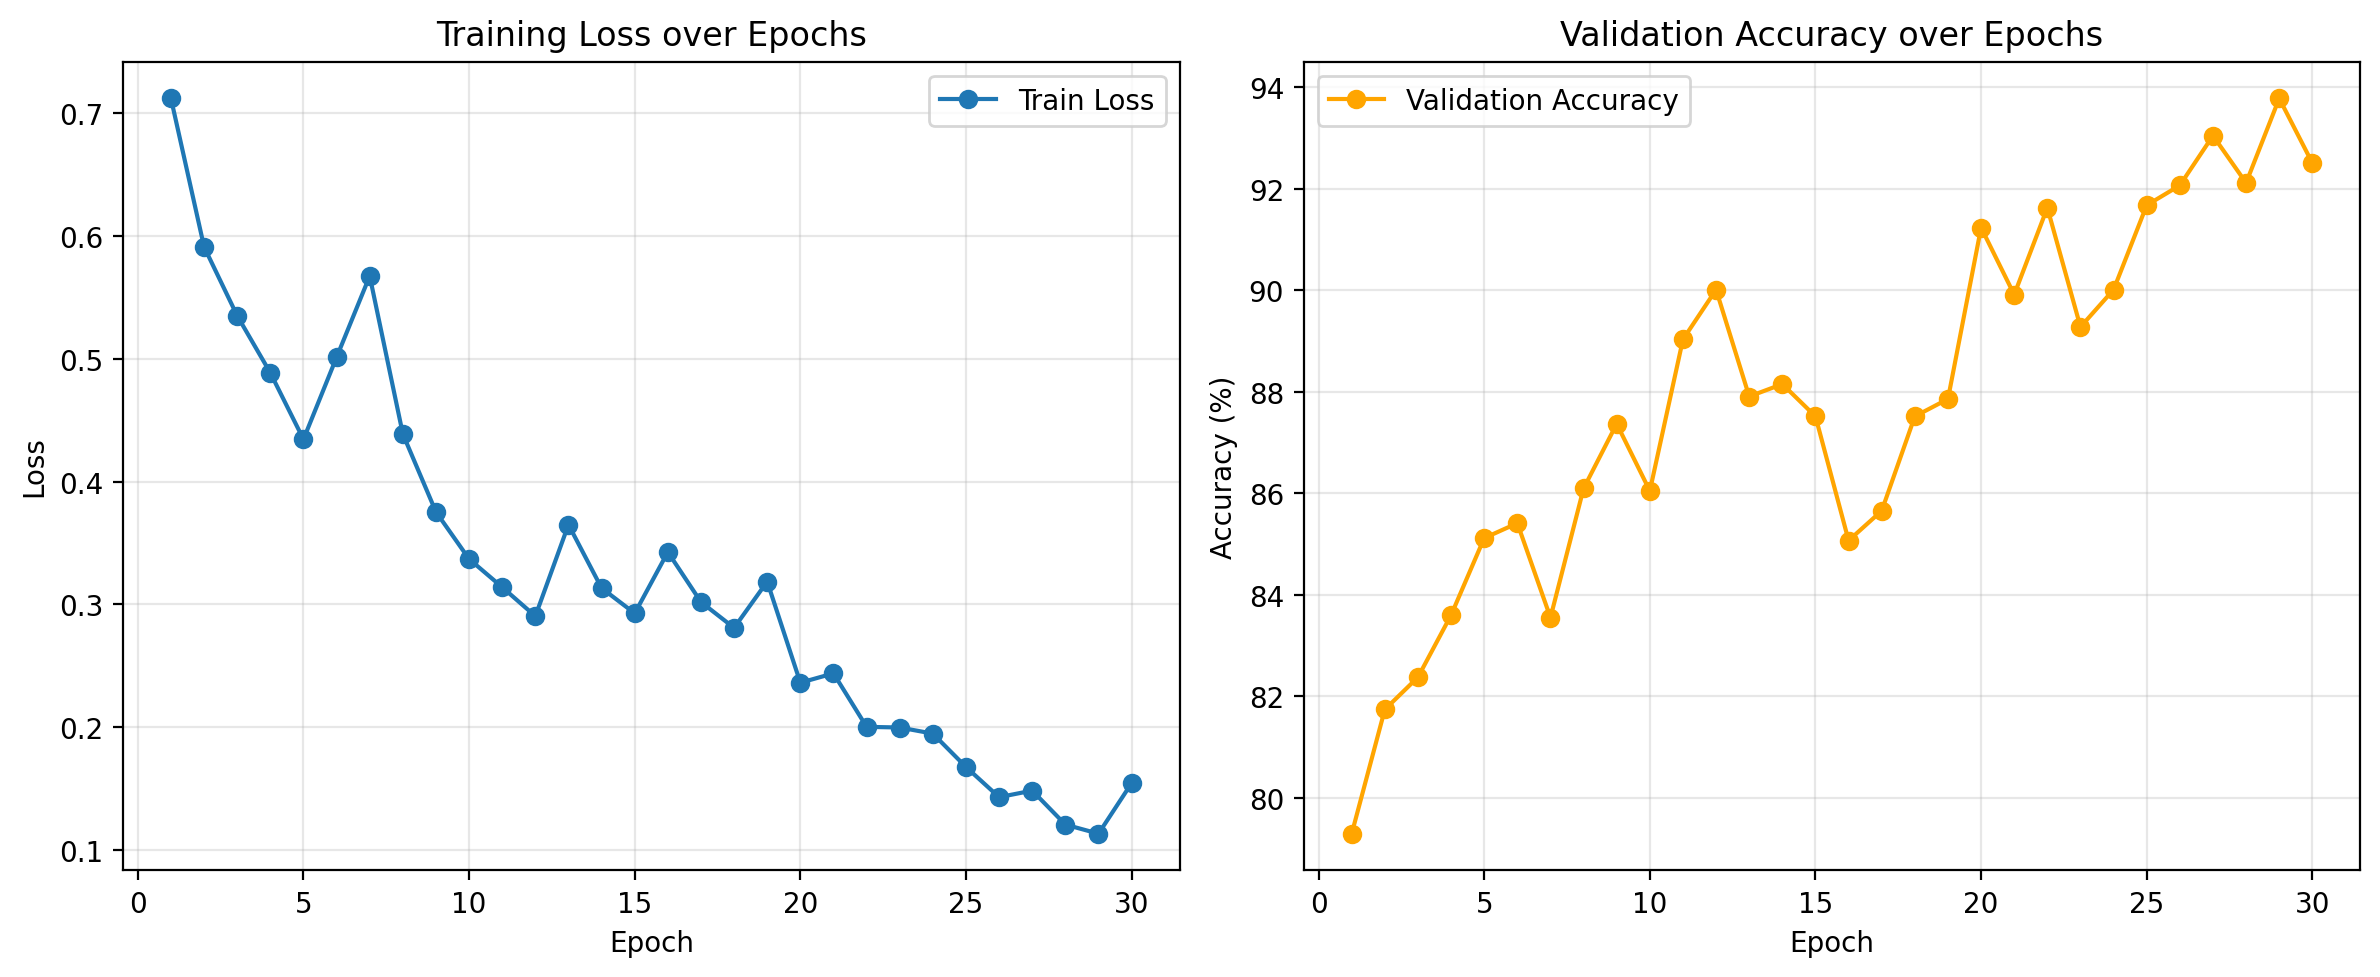

In [21]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True, alpha=0.3)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, marker='o', color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy over Epochs')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

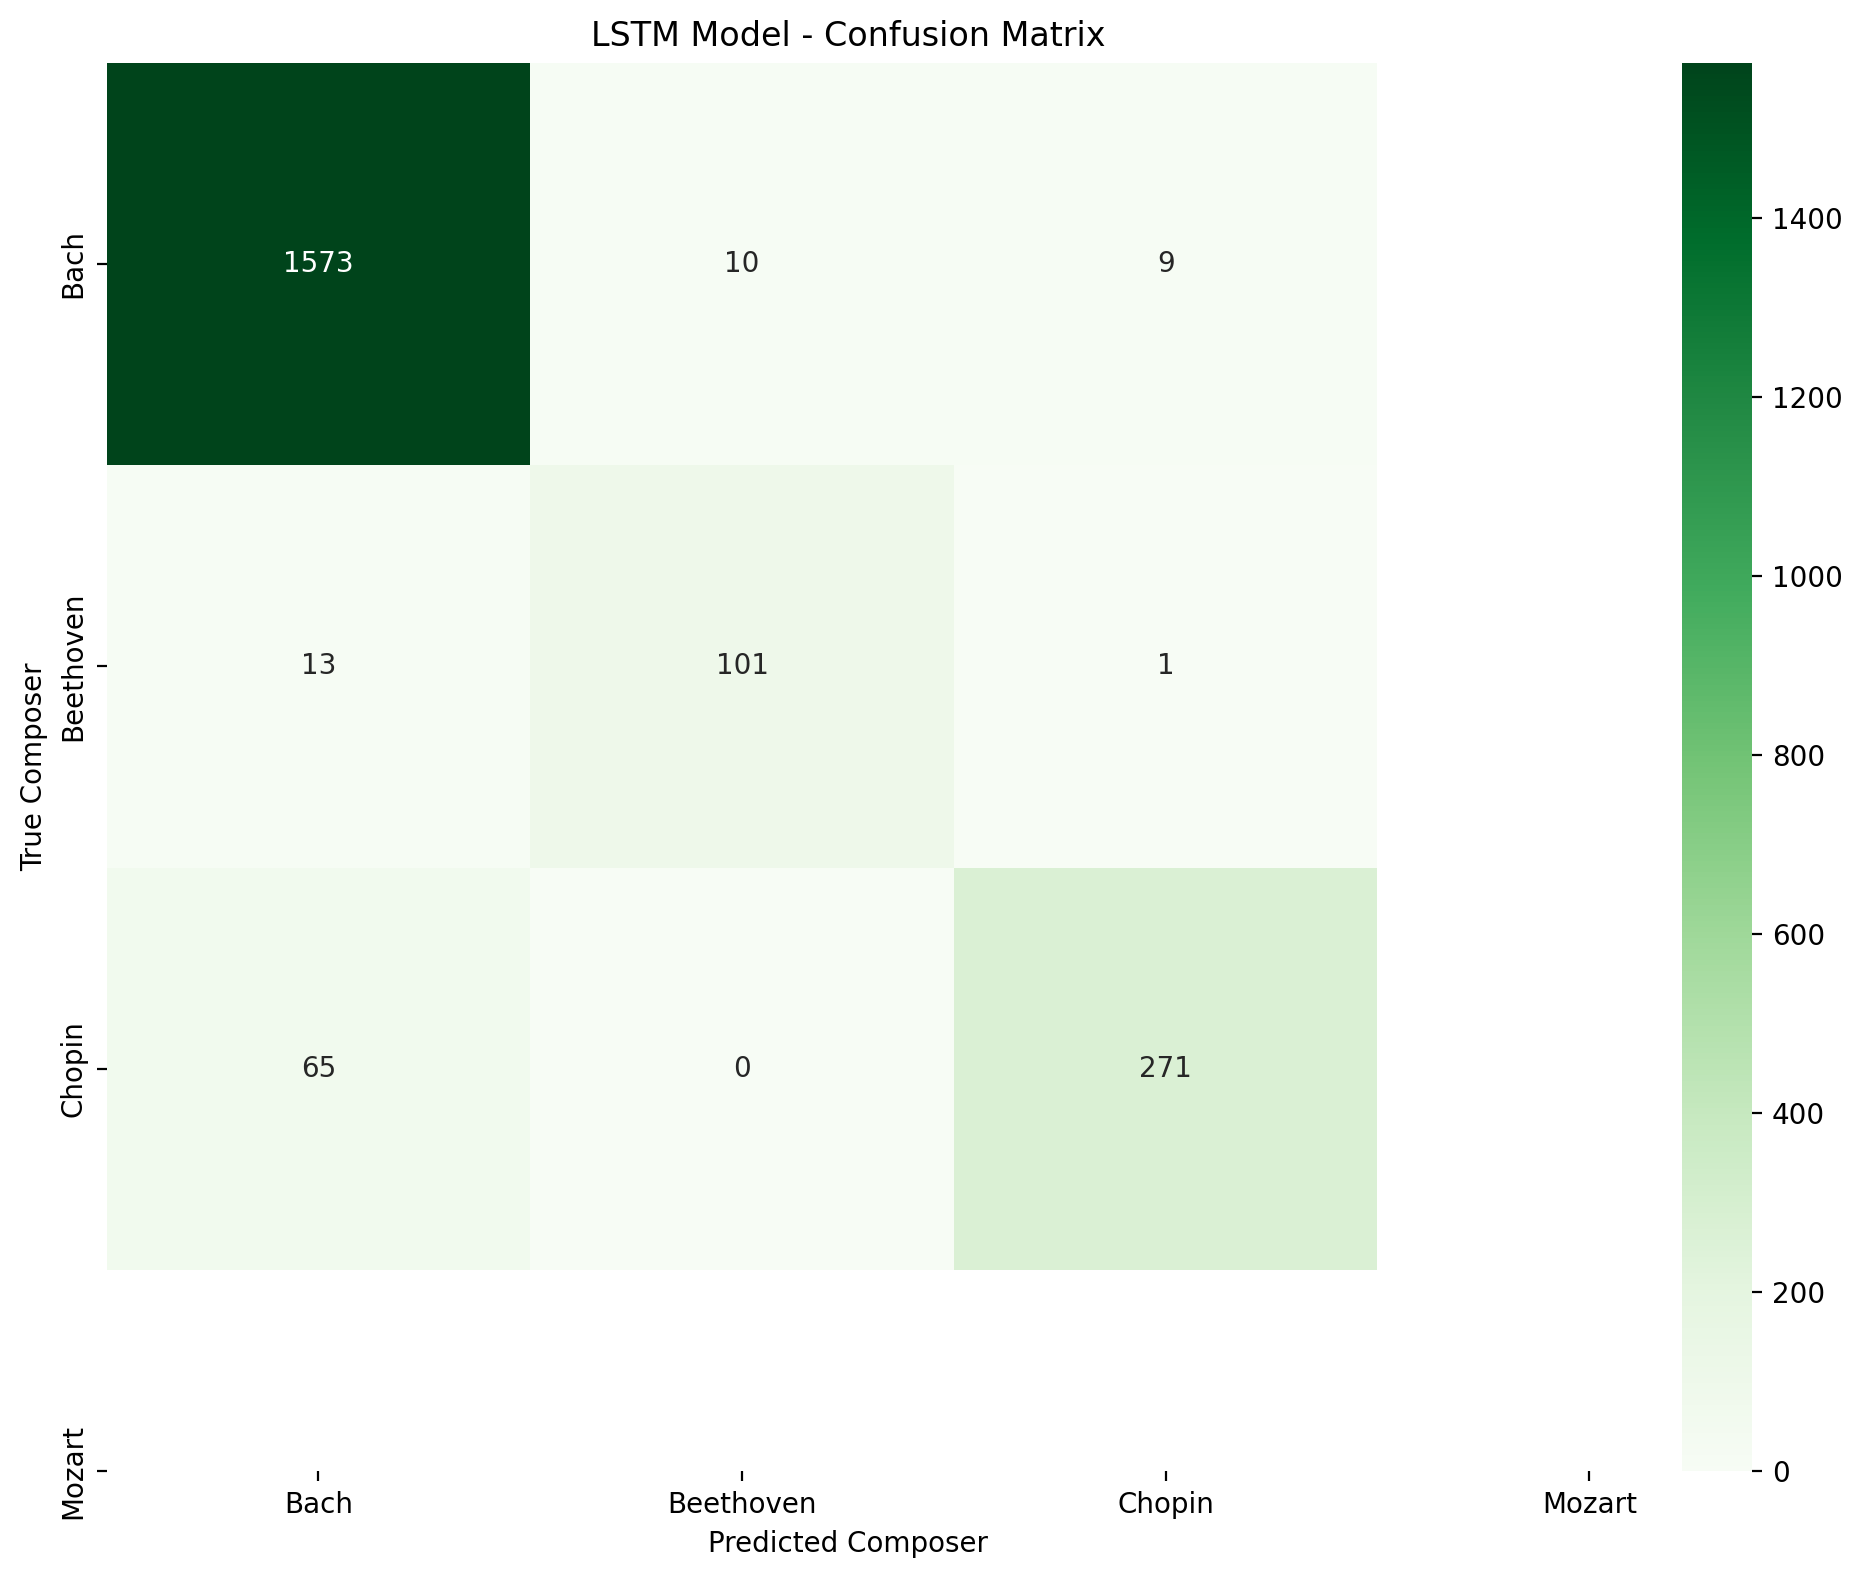

LSTM Classification Report:


ValueError: Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter

In [43]:
# LSTM Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Recreate LSTM data loaders for confusion matrix (they were deleted during CNN memory cleanup)
with open(os.path.join(OUTPUT_DIR, 'features_lstm.pkl'), 'rb') as f:
    X_lstm = pickle.load(f)
with open(os.path.join(OUTPUT_DIR, 'labels.pkl'), 'rb') as f:
    y_lstm = pickle.load(f)

X_lstm_tensor = torch.tensor(X_lstm, dtype=torch.float32)
y_lstm_tensor = torch.tensor(y_lstm, dtype=torch.long)

dataset_lstm = TensorDataset(X_lstm_tensor, y_lstm_tensor)
train_size = int(0.8 * len(dataset_lstm))
val_size = len(dataset_lstm) - train_size
train_ds_lstm, val_ds_lstm = random_split(dataset_lstm, [train_size, val_size])
val_loader_lstm = DataLoader(val_ds_lstm, batch_size=batch_size, pin_memory=True, num_workers=2)

# Get predictions on validation set for confusion matrix
lstm_model.eval()
y_true_lstm, y_pred_lstm = [], []
with torch.no_grad():
    for X_val, y_val in val_loader_lstm:
        X_val, y_val = X_val.to(DEVICE), y_val.to(DEVICE)
        outputs = lstm_model(X_val)
        _, predicted = torch.max(outputs.data, 1)
        y_true_lstm.extend(y_val.cpu().numpy())
        y_pred_lstm.extend(predicted.cpu().numpy())

# Create confusion matrix
cm_lstm = confusion_matrix(y_true_lstm, y_pred_lstm)
composer_names = [label_to_composer[i] for i in range(len(COMPOSERS))]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=composer_names, yticklabels=composer_names)
plt.title('LSTM Model - Confusion Matrix')
plt.xlabel('Predicted Composer')
plt.ylabel('True Composer')
plt.tight_layout()
plt.show()

# Print classification report
print("LSTM Classification Report:")
print(classification_report(y_true_lstm, y_pred_lstm, target_names=composer_names))

CNN Model training and evaluation

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def evaluate_model(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = logits.argmax(1)
            y_true.extend(yb.cpu().numpy())
            y_pred .extend(preds.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return acc, prec, rec, f1, confusion_matrix(y_true, y_pred)

In [ ]:
# Clear CUDA memory before CNN training to prevent out of memory errors
import gc

gc.collect()

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    print(f"CUDA memory cleared. Available memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"Currently allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"Currently cached: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

if 'X_tensor' in locals():
    del X_tensor
if 'y_tensor' in locals():
    del y_tensor
if 'dataset' in locals():
    del dataset
if 'train_ds' in locals():
    del train_ds
if 'val_ds' in locals():
    del val_ds
if 'train_loader' in locals():
    del train_loader
if 'val_loader' in locals():
    del val_loader

# Run garbage collection again after deletions
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"After cleanup - Currently allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

In [ ]:
with open(os.path.join(OUTPUT_DIR, 'features_cnn.pkl'), 'rb') as f:
    Xc = pickle.load(f)  # (N, P, T, 1)
Xc_tensor = torch.tensor(Xc, dtype=torch.float32).permute(0, 3, 1, 2)  # -> (N,1,P,T)
yc_tensor = torch.tensor(labels, dtype=torch.long)

ds_cnn = TensorDataset(Xc_tensor, yc_tensor)
train_size = int(0.8 * len(ds_cnn))
val_size   = len(ds_cnn) - train_size
train_cnn, val_cnn = random_split(ds_cnn, [train_size, val_size])

model_cnn = ComposerCNN(NUM_PITCHES, int(SEGMENT_DURATION_SECONDS * SAMPLES_PER_SECOND)).to(DEVICE)
opt_cnn = optim.Adam(model_cnn.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss().to(DEVICE)

# Initialize lists to store metrics for plotting
cnn_train_losses = []
cnn_val_accuracies = []

cnn_batch_size = 64  # Reduced from 128
train_cnn_loader = DataLoader(train_cnn, batch_size=cnn_batch_size, shuffle=True)
val_cnn_loader = DataLoader(val_cnn, batch_size=cnn_batch_size)

for epoch in range(num_epochs):
    model_cnn.train()
    epoch_train_loss = 0.0
    num_batches = 0
    
    for batch_idx, (xb, yb) in enumerate(train_cnn_loader):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt_cnn.zero_grad()
        
        # Use gradient accumulation if memory is still tight
        loss = crit(model_cnn(xb), yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_cnn.parameters(), 1.0)
        opt_cnn.step()
        
        epoch_train_loss += loss.item()
        num_batches += 1
        
        # Clear intermediate tensors to save memory
        del xb, yb, loss
        
        # Clear CUDA cache periodically during training
        if batch_idx % 50 == 0 and torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # Calculate average training loss for this epoch
    avg_train_loss = epoch_train_loss / num_batches
    cnn_train_losses.append(avg_train_loss)
    
    # Evaluate on validation set
    acc, prec, rec, f1, _ = evaluate_model(model_cnn, val_cnn_loader, DEVICE)
    cnn_val_accuracies.append(acc * 100)  # Convert to percentage
    
    print(f"[CNN] Epoch {epoch+1}: train_loss={avg_train_loss:.4f} acc={acc:.3f} P={prec:.3f} R={rec:.3f} F1={f1:.3f}")
    
    # Clear cache after each epoch
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Save the CNN model
torch.save(model_cnn.state_dict(), "composer_cnn_model.pth")

# Final memory cleanup
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"Training complete. Final memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

[CNN] Epoch 1: train_loss=0.4253 acc=0.912 P=0.912 R=0.818 F1=0.857
[CNN] Epoch 2: train_loss=0.2354 acc=0.927 P=0.899 R=0.923 F1=0.909
[CNN] Epoch 2: train_loss=0.2354 acc=0.927 P=0.899 R=0.923 F1=0.909
[CNN] Epoch 3: train_loss=0.1582 acc=0.949 P=0.963 R=0.897 F1=0.925
[CNN] Epoch 4: train_loss=0.1231 acc=0.962 P=0.945 R=0.951 F1=0.947
[CNN] Epoch 5: train_loss=0.0555 acc=0.979 P=0.972 R=0.971 F1=0.971
[CNN] Epoch 6: train_loss=0.0288 acc=0.976 P=0.960 R=0.978 F1=0.969
[CNN] Epoch 7: train_loss=0.0141 acc=0.987 P=0.981 R=0.983 F1=0.982
[CNN] Epoch 8: train_loss=0.0056 acc=0.988 P=0.989 R=0.978 F1=0.983
[CNN] Epoch 9: train_loss=0.0035 acc=0.987 P=0.984 R=0.981 F1=0.983
[CNN] Epoch 10: train_loss=0.0029 acc=0.989 P=0.986 R=0.983 F1=0.985
[CNN] Epoch 11: train_loss=0.0015 acc=0.990 P=0.991 R=0.980 F1=0.985
[CNN] Epoch 12: train_loss=0.0013 acc=0.990 P=0.989 R=0.984 F1=0.986
[CNN] Epoch 13: train_loss=0.0012 acc=0.991 P=0.992 R=0.980 F1=0.986
[CNN] Epoch 14: train_loss=0.0012 acc=0.990 

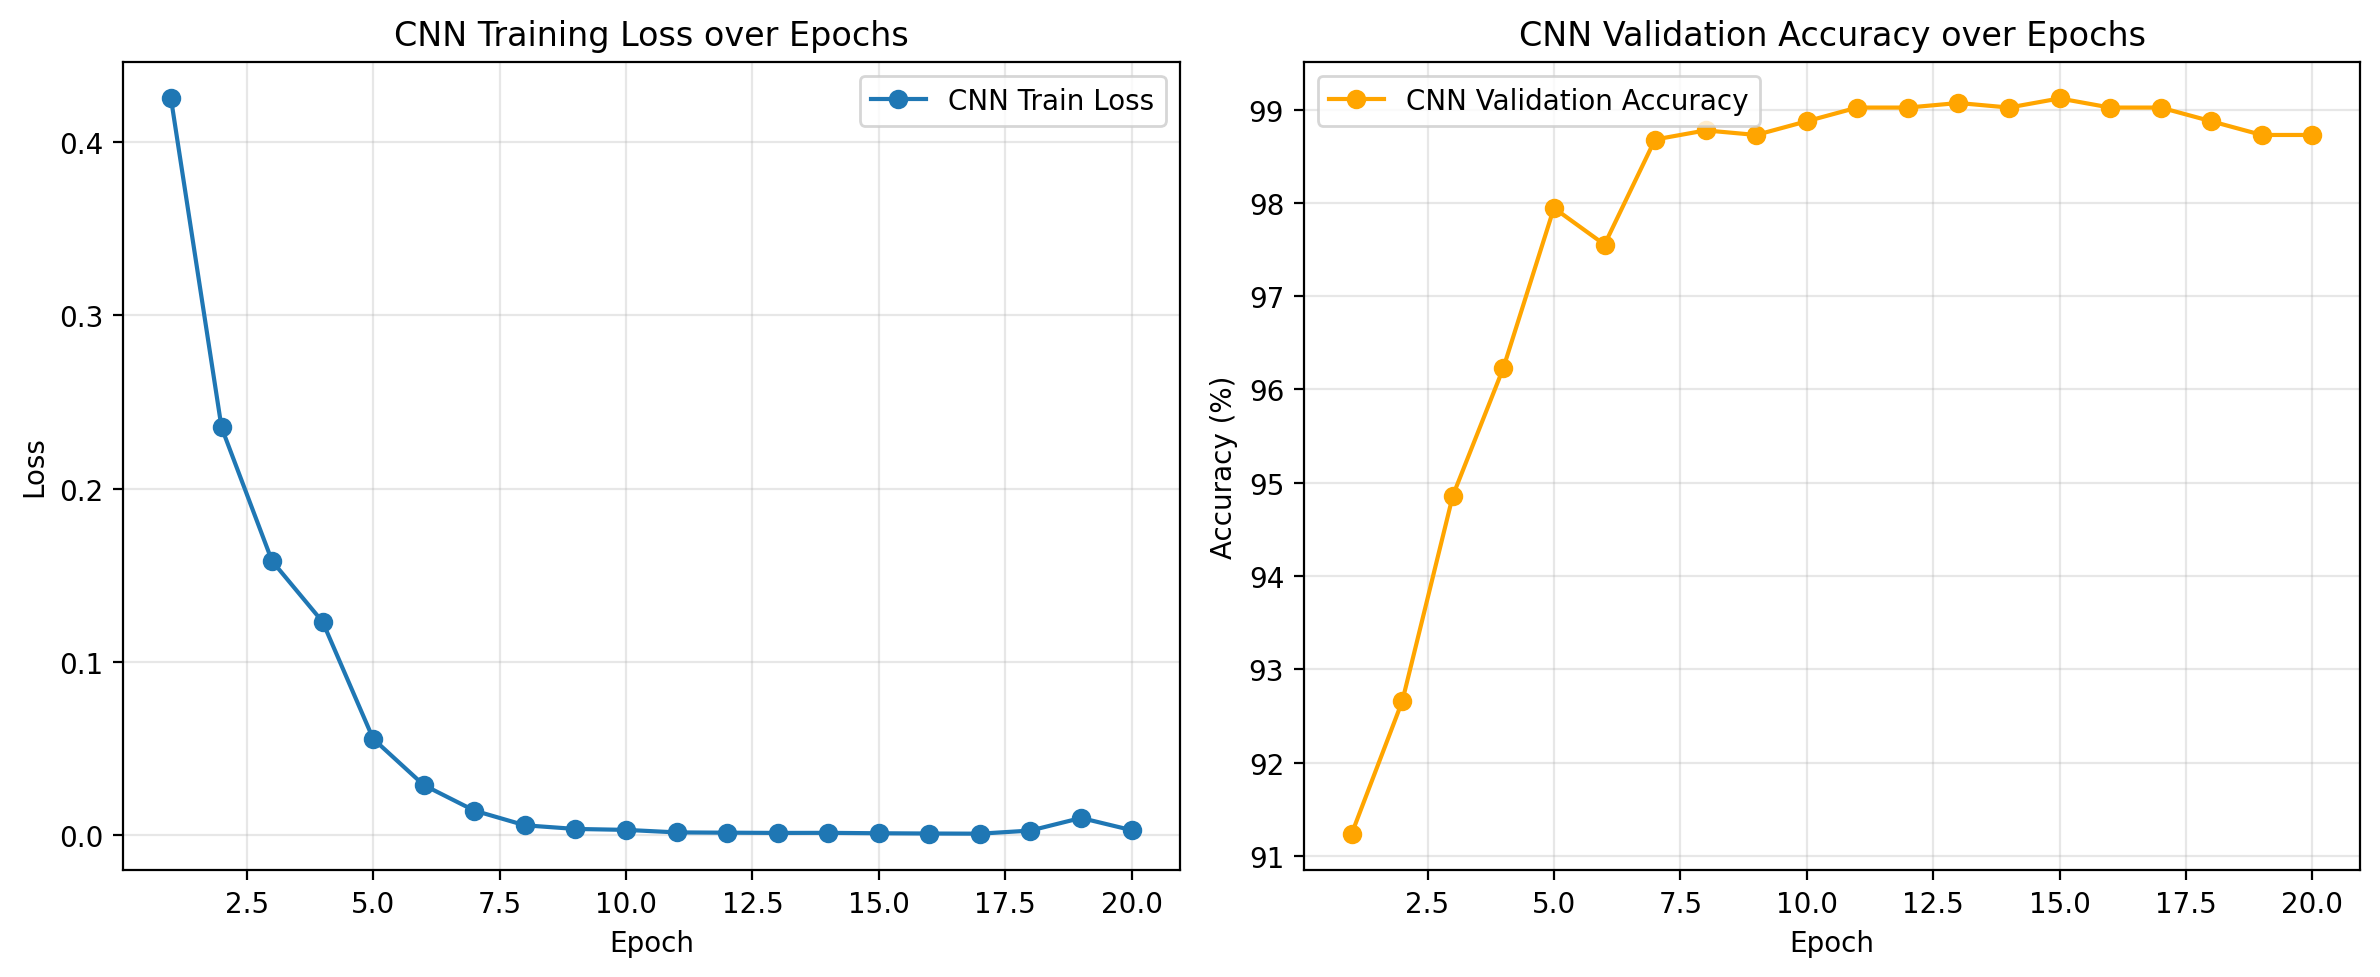

In [40]:
# Plot CNN Training and Validation Loss/Accuracy
epochs = range(1, len(cnn_train_losses) + 1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, cnn_train_losses, marker='o', label='CNN Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training Loss over Epochs')
plt.grid(True, alpha=0.3)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, cnn_val_accuracies, marker='o', color='orange', label='CNN Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('CNN Validation Accuracy over Epochs')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

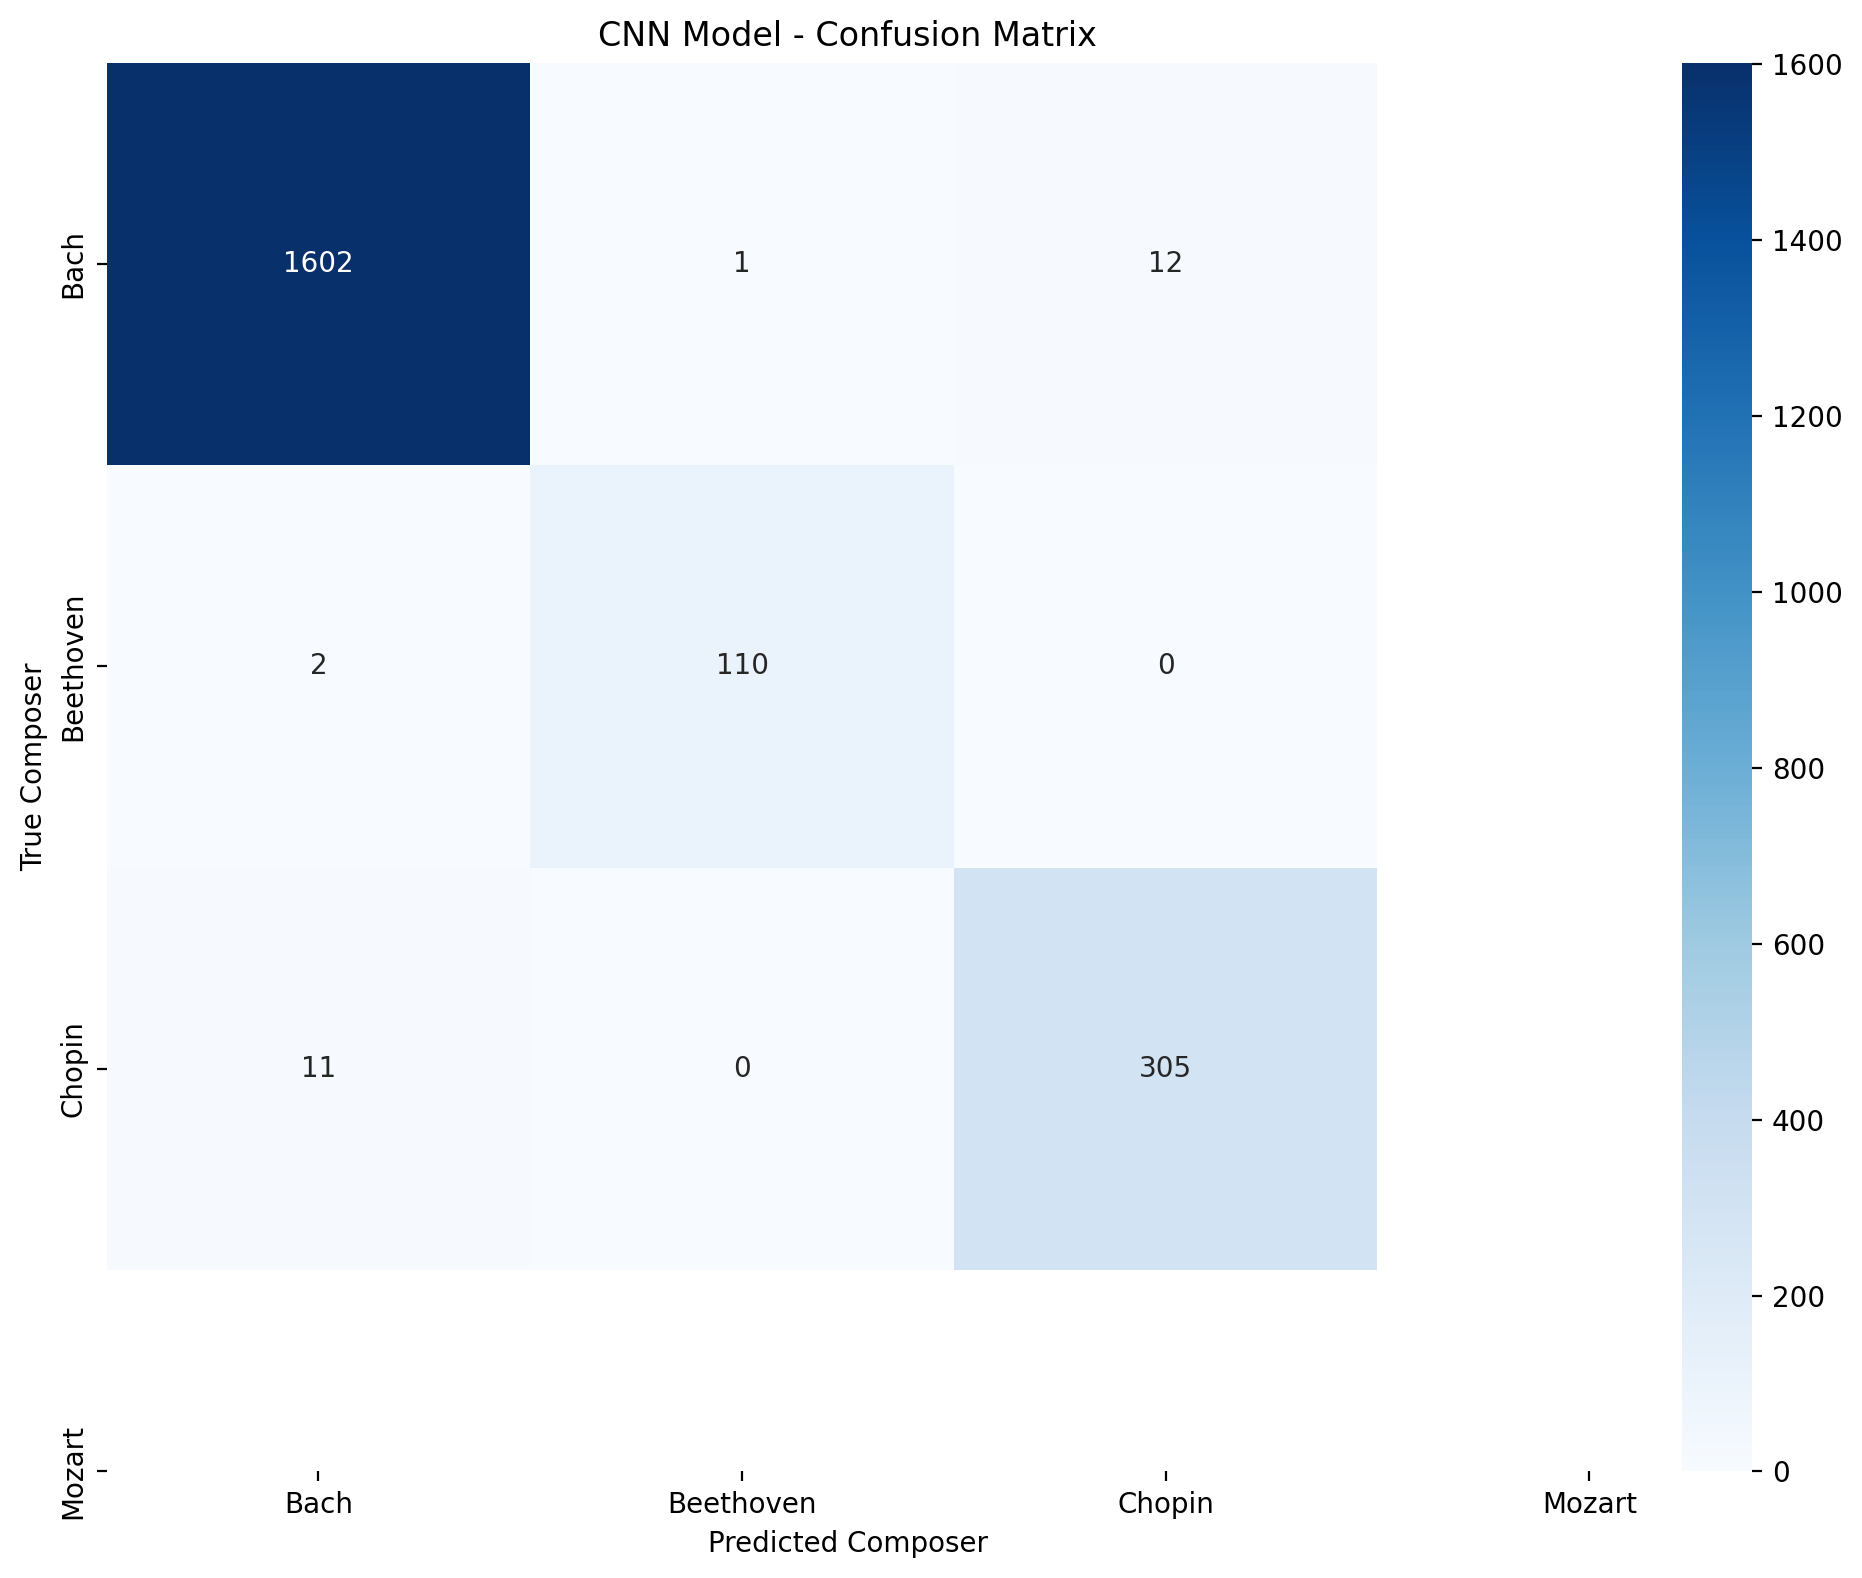

CNN Classification Report:


ValueError: Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter

In [41]:
# CNN Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions on validation set for confusion matrix
model_cnn.eval()
y_true_cnn, y_pred_cnn = [], []
with torch.no_grad():
    for xb, yb in val_cnn_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model_cnn(xb)
        preds = logits.argmax(1)
        y_true_cnn.extend(yb.cpu().numpy())
        y_pred_cnn.extend(preds.cpu().numpy())

# Create confusion matrix
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
composer_names = [label_to_composer[i] for i in range(len(COMPOSERS))]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=composer_names, yticklabels=composer_names)
plt.title('CNN Model - Confusion Matrix')
plt.xlabel('Predicted Composer')
plt.ylabel('True Composer')
plt.tight_layout()
plt.show()

# Print classification report
from sklearn.metrics import classification_report
print("CNN Classification Report:")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=composer_names))

In [24]:
class CNNEncoder(nn.Module):
    def __init__(self, out_channels=64):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, out_channels, kernel_size=3, padding=1)
        # pool over pitch only: (2,1) halves pitch, keeps time
        self.pool_pitch = nn.MaxPool2d(kernel_size=(2,1))

    def forward(self, x):
        # x: (N, 1, P, T)
        x = torch.relu(self.conv1(x))
        x = self.pool_pitch(x)             # (N, 32, P/2, T)
        x = torch.relu(self.conv2(x))
        x = self.pool_pitch(x)             # (N, C, P/4, T)
        # global average over remaining pitch bins -> (N, C, 1, T)
        x = x.mean(dim=2, keepdim=True)
        x = x.squeeze(2)                   # (N, C, T)
        x = x.permute(0, 2, 1)             # (N, T, C)
        return x


In [25]:
class FusionLSTM(nn.Module):
    def __init__(self, seq_input_size, cnn_feat_size, hidden_size, num_layers, num_classes, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=seq_input_size + cnn_feat_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout,
                            bidirectional=False)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, seq_feats, cnn_feats):
        # seq_feats: (N, T, 13), cnn_feats: (N, T, C)
        x = torch.cat([seq_feats, cnn_feats], dim=-1)  # (N, T, 13+C)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

In [26]:
import torch

# LSTM features
X_seq = torch.tensor(features_lstm, dtype=torch.float32)               # (N, T, 13)

# CNN piano-roll features -> (N,1,P,T)
X_roll = torch.tensor(features_cnn, dtype=torch.float32).permute(0,3,1,2)
y_t = torch.tensor(labels, dtype=torch.long)

# Create a TensorDataset for the combined features
dataset_full = TensorDataset(X_seq, X_roll, y_t)


/tmp/ipykernel_78873/2099519306.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X_seq = torch.tensor(features_lstm, dtype=torch.float32)               # (N, T, 13)


In [27]:
# Split the dataset into training and validation sets
train_size = int(0.8*len(dataset_full))
train_ds, val_ds = random_split(dataset_full, [train_size, len(dataset_full) - train_size])

In [28]:
# For testing, reduce the size of the training set
#frac = 0.2  # use 20% for quick tests

# Randomly select a subset of the training set
#y_t = y_t[train_ds.indices]  # Get the labels for the training set
#N = len(y_t)
#idx = torch.randperm(N)
#sub_idx = idx[:int(N * frac)]

#dataset_sub  = Subset(dataset_full, sub_idx)

# Split AFTER subsetting (keeps test quick too)
#sub_train_size = int(0.8 * len(dataset_sub))
#train_ds, val_ds = random_split(dataset_sub, [sub_train_size, len(dataset_sub) - sub_train_size])

In [29]:

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=64, pin_memory=True, num_workers=2)

In [30]:
cnn_enc = CNNEncoder(out_channels=64).to(DEVICE)
fusion_model   = FusionLSTM(seq_input_size=13, cnn_feat_size=64,
                     hidden_size=128, num_layers=2,
                     num_classes=len(COMPOSERS), dropout=0.3).to(DEVICE)

params = list(cnn_enc.parameters()) + list(fusion_model.parameters())
optimizer = optim.Adam(params, lr=1e-3)
criterion = nn.CrossEntropyLoss().to(DEVICE)


In [31]:
def compute_cls_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    return acc, prec, rec, f1

In [32]:

def evaluate_fusion(cnn_enc, fusion_model, loader, device):
    cnn_enc.eval(); fusion_model.eval()
    y_true, y_pred = [], []
    running_loss = 0.0
    with torch.no_grad():
        for seq_b, roll_b, yb in loader:
            seq_b, roll_b, yb = seq_b.to(device, non_blocking=True), roll_b.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            cnn_feats = cnn_enc(roll_b)           # (N,T,C)
            logits = fusion_model(seq_b, cnn_feats)
            loss = criterion(logits, yb)
            running_loss += loss.item()
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(logits.argmax(1).cpu().numpy())
    acc, prec, rec, f1 = compute_cls_metrics(y_true, y_pred)
    return running_loss / max(1, len(loader)), acc, prec, rec, f1

In [33]:
logger = {"epoch": [], "train_loss": [], "val_loss": [],
          "val_acc": [], "val_prec": [], "val_rec": [], "val_f1": []}

scaler = torch.amp.GradScaler(DEVICE.type)
num_epochs = 20

# Training loop for the fusion model
for epoch in range(num_epochs):
    cnn_enc.train()
    fusion_model.train()
    running = 0.0
    print(f"Epoch {epoch+1}/{num_epochs}")
    for seq_batch, roll_batch, y_batch in train_loader:
        seq_batch = seq_batch.to(DEVICE)          # (N,T,13)
        roll_batch = roll_batch.to(DEVICE)        # (N,1,P,T)
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(DEVICE.type):
          cnn_feats = cnn_enc(roll_batch)           # (N,T,64)
          logits = fusion_model(seq_batch, cnn_feats)      # (N,num_classes)
          loss = criterion(logits, y_batch)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(params, 1.0)
        scaler.step(optimizer)
        scaler.update()
        running += loss.item()

    # … your existing evaluate_model(val_loader) adapted to take (seq, roll, y) …
    val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate_fusion(cnn_enc, fusion_model, val_loader, DEVICE)
    print(f"Train Loss: {running/len(train_loader):.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Acc: {val_acc:.4f}, "
          f"Val Prec: {val_prec:.4f}, "
          f"Val Rec: {val_rec:.4f}, "
          f"Val F1: {val_f1:.4f}")

    # Log the results
    logger["epoch"].append(epoch+1)
    logger["train_loss"].append(running / max(1, len(train_loader)))
    logger["val_loss"].append(val_loss)
    logger["val_acc"].append(val_acc)
    logger["val_prec"].append(val_prec)
    logger["val_rec"].append(val_rec)
    logger["val_f1"].append(val_f1)

    print(f"Epoch {epoch+1:02d} | train_loss={logger['train_loss'][-1]:.4f} "
          f"| val_loss={val_loss:.4f} | acc={val_acc:.3f} | P={val_prec:.3f} | R={val_rec:.3f} | F1={val_f1:.3f}")

# Save the trained model
torch.save({
    'cnn_encoder_state_dict': cnn_enc.state_dict(),
    'fusion_model_state_dict': fusion_model.state_dict(),
}, 'composer_fusion_model.pth')


Epoch 1/20
Train Loss: 0.7377, Val Loss: 0.6234, Val Acc: 0.7778, Val Prec: 0.2593, Val Rec: 0.3333, Val F1: 0.2917
Epoch 01 | train_loss=0.7377 | val_loss=0.6234 | acc=0.778 | P=0.259 | R=0.333 | F1=0.292
Epoch 2/20
Train Loss: 0.5588, Val Loss: 0.5422, Val Acc: 0.8140, Val Prec: 0.4949, Val Rec: 0.4759, Val F1: 0.4804
Epoch 02 | train_loss=0.5588 | val_loss=0.5422 | acc=0.814 | P=0.495 | R=0.476 | F1=0.480
Epoch 3/20
Train Loss: 0.4938, Val Loss: 0.4806, Val Acc: 0.8169, Val Prec: 0.5038, Val Rec: 0.4662, Val F1: 0.4754
Epoch 03 | train_loss=0.4938 | val_loss=0.4806 | acc=0.817 | P=0.504 | R=0.466 | F1=0.475
Epoch 4/20
Train Loss: 0.4628, Val Loss: 0.4557, Val Acc: 0.8404, Val Prec: 0.7207, Val Rec: 0.5349, Val F1: 0.5791
Epoch 04 | train_loss=0.4628 | val_loss=0.4557 | acc=0.840 | P=0.721 | R=0.535 | F1=0.579
Epoch 5/20
Train Loss: 0.4750, Val Loss: 0.4669, Val Acc: 0.8370, Val Prec: 0.7630, Val Rec: 0.4796, Val F1: 0.5083
Epoch 05 | train_loss=0.4750 | val_loss=0.4669 | acc=0.837 |

Model Evaluation: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.


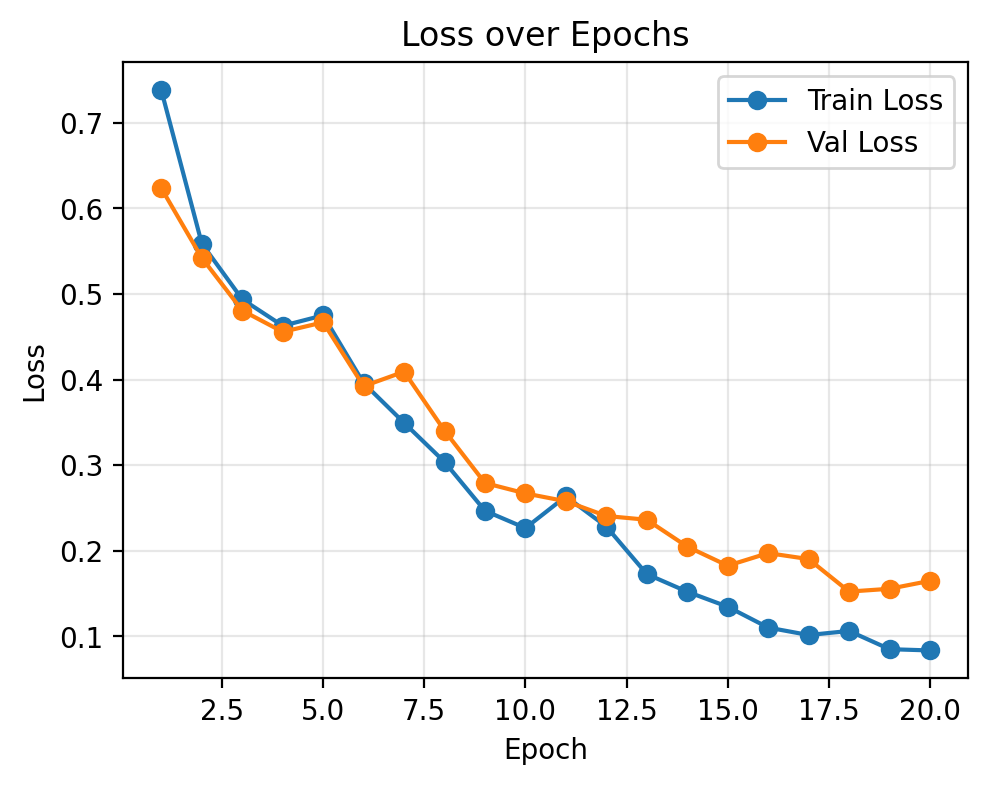

In [34]:
# Plotting the training and validation metrics
epochs = logger["epoch"]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, logger["train_loss"], marker='o', label='Train Loss')
plt.plot(epochs, logger["val_loss"],   marker='o', label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss over Epochs'); plt.legend(); plt.grid(True, alpha=0.3)


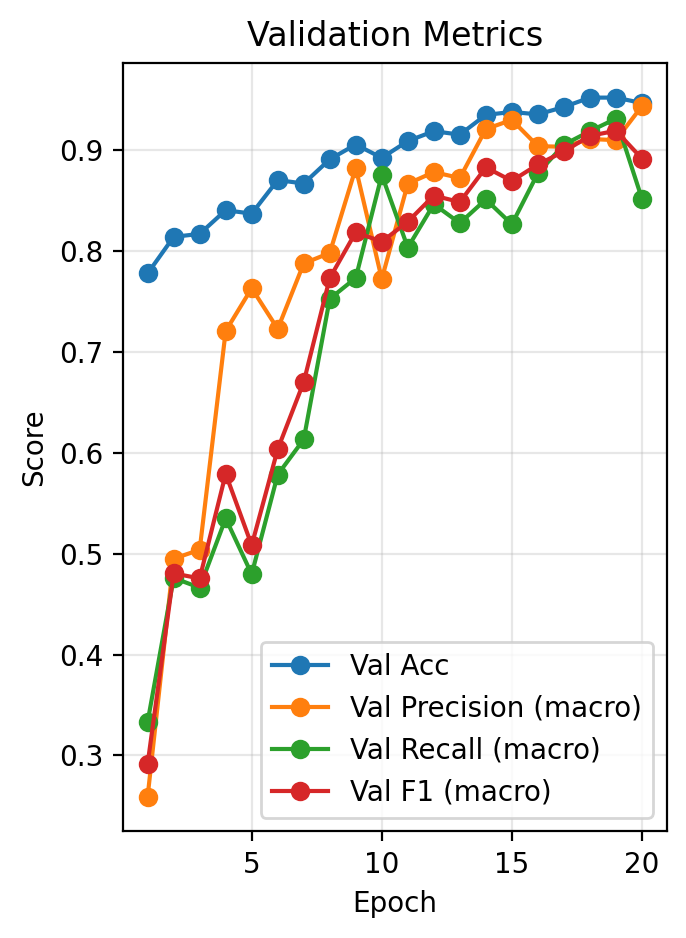

In [35]:

plt.subplot(1,2,2)
plt.plot(epochs, logger["val_acc"],  marker='o', label='Val Acc')
plt.plot(epochs, logger["val_prec"], marker='o', label='Val Precision (macro)')
plt.plot(epochs, logger["val_rec"],  marker='o', label='Val Recall (macro)')
plt.plot(epochs, logger["val_f1"],   marker='o', label='Val F1 (macro)')
plt.xlabel('Epoch'); plt.ylabel('Score'); plt.title('Validation Metrics'); plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Model Optimization: Optimize the deep learning model by fine-tuning hyperparameters.